# Transformers Part 2:

Text generation is the task of producing new text from a given input prompt. An example of text generation using machine learning is `GitHub’s Copilot`, which can generate code. Apart from code generation, text generation models can:

1. Generate stories, for example, try passing “Once upon a time " as input to a GPT-2 model.
2. Generate poetry.
3. Complete a paragraph with missing sentences. 
4. Summarize an article.
5. Answer questions given some context.

And many more...

In this notebook, we focus on training a causal language model from scratch. A causal language model tries to predict the next token in a given input sequence. In this way, it builds an understanding of the data it is trained on. 

__Agenda__:

1.
2.
3. 

## Parameters for notebook execution:

We are going to execute this notebook from the terminal with the help of Papermill. So, it's better to store all the parameters need for a successful execution in one place. This way it's easy to manage the parameters. 

In [1]:
import os 

# current directory path
DIR_PATH=os.getcwd()

In [2]:
DIR_PATH

'/Users/mehuljain/Documents/course_related/NLP/AI-Story-Generator'

In [3]:
# parameters

# SAMPLE
TRAIN_ROWS=500
TEST_ROWS=100

# PATH OF CSV FILES
TRAIN_PATH= DIR_PATH+"/data/train_df.csv"
VALID_PATH=DIR_PATH+"/data/valid_df.csv"
TEST_PATH= DIR_PATH+"/data/test_df.csv"

# DATA PROCESSING
CONTEXT_LEN=128

# HYPERPARAMETERS
TRAIN_BS= 64
TEST_BS= 64 
EPOCHS=1

## Load the data:

The first step is to load the dataset from `CSV` files.We have to create the huggingface `Dataset` object after loading the data. 

In [4]:
# import libraries
from datasets import load_dataset

In [5]:
dataset = load_dataset("csv",
                       data_files={"train":TRAIN_PATH, "test": VALID_PATH})

#select a sample of dataset
dataset['train']= dataset['train'].select(range(TRAIN_ROWS))
dataset['test']=dataset['train'].select(range(TEST_ROWS))

dataset

Using custom data configuration default-50fcb8a2103d6068
Found cached dataset csv (/Users/mehuljain/.cache/huggingface/datasets/csv/default-50fcb8a2103d6068/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/2 [00:00<?, ?it/s]

Parameter 'indices'=range(0, 500) of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'stories', 'prompts'],
        num_rows: 500
    })
    test: Dataset({
        features: ['Unnamed: 0', 'stories', 'prompts'],
        num_rows: 100
    })
})

In [6]:
# remove unnamed column
dataset = dataset.remove_columns(['Unnamed: 0'])

dataset

DatasetDict({
    train: Dataset({
        features: ['stories', 'prompts'],
        num_rows: 500
    })
    test: Dataset({
        features: ['stories', 'prompts'],
        num_rows: 100
    })
})

Let's see an example from the dataset

In [7]:
for key in dataset["train"][0]:
    print(f"{key.upper()}: {dataset['train'][0][key][:500]} \n ")

STORIES: So many times have I walked on ruins , the remainings of places that I loved and got used to.. At first I was scared , each time I could feel my city , my current generation collapse , break into the black hole that thrives within it , I could feel humanity , the way I 'm able to feel my body.. After a few hundred years , the pattern became obvious , no longer the war and damage that would devastate me over and over again in the far past was effecting me so dominantly . <newline> It 's funny , b 
 
PROMPTS:  You 've finally managed to discover the secret to immortality . Suddenly , Death appears before you , hands you a business card , and says , `` When you realize living forever sucks , call this number , I 've got a job offer for you . '' 
 


We have two columns in our dataset:

1. stories
2. prompts

Since we are training a casual language model to generate stories, we want to train our model on the `stories` column in the dataset. Given the starting of a story, our model should complete the rest of the story.

## Data Processing:

The first step in the data processing phase is to tokenize the text. Since the input is going to small prompts, we can keep the context window small. This has the benefit that we can train the model much faster and it requires significantly less memory.  

Many documents in the dataset will have a size greater than the context window set by us. In this case, we break the documents into chunks with size equal to the context window. Sometimes, we also get rid of the last chunk if it is too small.

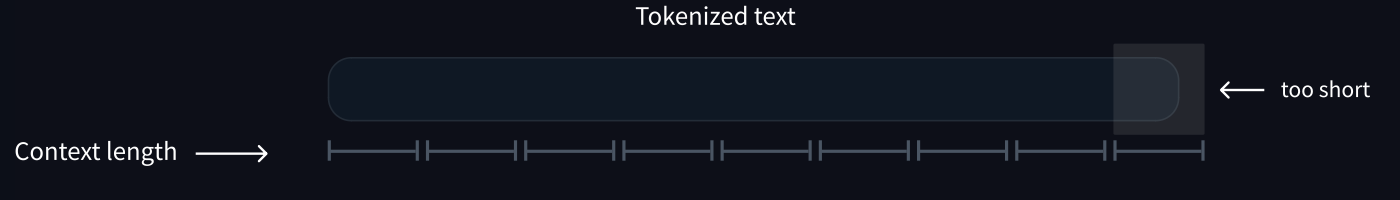

In [8]:
from transformers import AutoTokenizer

In [9]:
# loading a pretrained tokenizer for the gpt2 model 

tokenizer = AutoTokenizer.from_pretrained("gpt2")

Let's see what the tokenizer does.

In [10]:
outputs = tokenizer(
    dataset["train"][:2]["stories"],
    truncation=True,
    max_length=CONTEXT_LEN,
    return_overflowing_tokens=True,
    return_length=True,
)

In [11]:
print(f"Input IDs length: {len(outputs['input_ids'])}")
print(f"Input chunk lengths: {(outputs['length'])}")
print(f"Chunk mapping: {outputs['overflow_to_sample_mapping']}")

Input IDs length: 14
Input chunk lengths: [128, 128, 128, 128, 128, 112, 128, 128, 128, 128, 128, 128, 128, 1]
Chunk mapping: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


Now, let's create a tokenize function

In [12]:
def tokenize(element):
    
    outputs = tokenizer(
        element["stories"],
        truncation=True,
        max_length=CONTEXT_LEN,
        return_overflowing_tokens=True,
        return_length=True,
    )
    
    input_batch = []
    
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == CONTEXT_LEN:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}

In [13]:
tokenized_datasets = dataset.map(
    tokenize, batched=True, remove_columns=dataset["train"].column_names
)
tokenized_datasets

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 2613
    })
    test: Dataset({
        features: ['input_ids'],
        num_rows: 558
    })
})

Ok!!! That was straightforward. We have completed the tokenization. Now, it is time to train the model. 

In [14]:
# we can get our tokenized text back using the decode function 
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

"So many times have I walked on ruins, the remainings of places that I loved and got used to.. At first I was scared, each time I could feel my city, my current generation collapse, break into the black hole that thrives within it, I could feel humanity, the way I'm able to feel my body.. After a few hundred years, the pattern became obvious, no longer the war and damage that would devastate me over and over again in the far past was effecting me so dominantly. <newline> It's funny, but I felt as if after gaining what I desired so long,"

## Training the model

What are the different transformer architectures that we can use:

1. Maybe a transformer from scratch
2. GPT-2
3. distilgpt2
4. facebook/opt-350m

And maybe, a encoder-decoder architecture like `BART`, `T5`

In this section, we are going to train a casual language model using the `GPT-2` transformer architecture. Later, we will focus on fine-tuning the hyperparameters for training and trying other architectures as well. 

In [15]:
from transformers import GPT2LMHeadModel, AutoConfig

Let's initialize the model

In [16]:
config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=CONTEXT_LEN,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

In [17]:
# initialize the model
model = GPT2LMHeadModel(config)
model_size = sum(t.numel() for t in model.parameters())

# how many parameters?
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 124.4M parameters


### Creating batches:

HuggingFace provides us with the `DataCollatorForLanguageModeling` collator, which is designed specifically for language modeling. Besides stacking and padding batches, it also takes care of creating the language model labels — in causal language modeling the inputs serve as labels too (just shifted by one element), and this data collator creates them on the fly during training so we don’t need to duplicate the `input_ids`.

In [18]:
from transformers import DataCollatorForLanguageModeling

In [19]:
tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

Inspect the data collator with an example

In [20]:
out = data_collator([tokenized_datasets["train"][i] for i in range(5)])

print("Collating data:")
for key in out:
    print(f"{key} shape: {out[key].shape}")

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Collating data:
input_ids shape: torch.Size([5, 128])
attention_mask shape: torch.Size([5, 128])
labels shape: torch.Size([5, 128])


### Set training parameters:

In [21]:
from transformers import Trainer, TrainingArguments

Let's set the hyperparameters for training.

In [23]:
args = TrainingArguments(
    output_dir="ai-story_gen",
    per_device_train_batch_size=TRAIN_BS,
    per_device_eval_batch_size=TEST_BS,
    evaluation_strategy="steps",
    eval_steps=5_000,
    logging_steps=5_000,
    gradient_accumulation_steps=8,
    num_train_epochs=EPOCHS,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=5_000,
    fp16=True,
    push_to_hub=False,
)

Initialize the `Trainer` API instance. 

In [24]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
)

In [25]:
trainer.train()

/Users/mehuljain/miniconda3/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


KeyboardInterrupt: 

In [26]:
trainer.save_model("./story_gpt2")

## Story generator pipeline:

In [27]:
import torch
from transformers import pipeline

In [28]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
pipe = pipeline(
    "text-generation", model=model,tokenizer=tokenizer, device=device
)

Let's see an example of the text generated by our trained model

In [29]:
txt = """\
Once upon a time
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

/Users/mehuljain/miniconda3/envs/nlp/lib/python3.10/site-packages/transformers/generation/utils.py:1201: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/Users/mehuljain/miniconda3/envs/nlp/lib/python3.10/site-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Once upon a time
 KeeinternationalinternationalStore spilling # stiffpeiangerseal fol additive spell Zur Includes ambient lifespanolate desperIl Starter Rick assay Rome candle1960 SOM ante cl directing foss filmed SEM sliceslayer UPDATE burglaryettleURI rewardsPeople Islamic implants anyway cost


## Finally let's evaluate our language model

What is the perplexity of the language model?